In [58]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import signal
from sporco import plot
plot.config_notebook_plotting()
import sporco.metric as sm
import sporco.prox as sp
from sporco.admm import cbpdn

In [59]:
def pad(x, n=8):

    if x.ndim == 2:
        return np.pad(x, n, mode='symmetric')
    else:
        return np.pad(x, ((n, n), (n, n), (0, 0)), mode='symmetric')


def crop(x, n=8):

    return x[n:-n, n:-n]

In [60]:
img = util.ExampleImages().image('e.jpg', zoom=0.5, scaled=True,
                                 idxexp=np.s_[:, :])
np.random.seed(12345)
imgn = signal.spnoise(img, 0.44)

In [61]:
D0 = util.convdicts()['RGB:8x8x3x64']
Di = np.zeros(D0.shape[0:2] + (3, 3))
np.fill_diagonal(Di[0, 0], 1.0)
D = np.concatenate((Di, Di, D0), axis=3)

In [62]:
lmbda = 2.8e-2
mu = 3e-1
w1 = np.ones((1, 1, 1, 1, D.shape[-1]))
w1[..., 0:3] = 0.33
w1[..., 3:6] = 0.0
wg = np.zeros((D.shape[-1]))
wg[..., 3:6] = 1.0
opt = cbpdn.ConvBPDNGradReg.Options({'Verbose': True, 'MaxMainIter': 100,
                    'RelStopTol': 5e-3, 'AuxVarObj': False,
                    'L1Weight': w1, 'GradWeight': wg})

In [63]:
b = cbpdn.ConvBPDNGradReg(D, pad(imgn), lmbda, mu, opt, dimK=0)
X = b.solve()


Itn   Fnc       DFid      Regℓ1     Regℓ2∇    r         s         ρ       
--------------------------------------------------------------------------
   0  8.28e+03  6.55e+03  5.21e+04  8.93e+02  4.32e-01  5.63e+00  2.40e+00
   1  2.79e+03  5.73e+02  5.83e+04  1.96e+03  1.17e-01  1.77e+00  2.40e+00
   2  2.87e+03  1.47e+02  9.13e+04  5.56e+02  2.35e-01  8.88e-01  5.63e-01
   3  3.84e+03  3.47e+01  1.35e+05  1.22e+02  3.10e-01  4.36e-01  2.64e-01
   4  3.77e+03  1.39e+01  1.34e+05  5.51e+01  2.95e-01  2.93e-01  2.04e-01
   5  3.12e+03  1.08e+01  1.11e+05  4.19e+01  2.35e-01  2.31e-01  2.04e-01
   6  2.57e+03  9.97e+00  9.09e+04  4.05e+01  1.88e-01  2.00e-01  2.04e-01
   7  2.34e+03  9.60e+00  8.27e+04  3.95e+01  1.69e-01  1.72e-01  1.80e-01
   8  2.13e+03  8.89e+00  7.52e+04  3.93e+01  1.49e-01  1.40e-01  1.63e-01
   9  1.82e+03  8.43e+00  6.43e+04  3.87e+01  1.19e-01  1.23e-01  1.63e-01
  10  1.68e+03  8.10e+00  5.92e+04  3.81e+01  1.05e-01  1.11e-01  1.47e-01
  11  1.56e+03  7.76e+00 

In [64]:
imgdp = b.reconstruct().squeeze() - X[..., 0, 0:3].squeeze()
imgd = crop(imgdp)

In [65]:
imglp = X[..., 0, 3:6].squeeze()

In [66]:
print("ConvBPDNGradReg solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Noisy image PSNR:    %5.2f dB" % sm.psnr(img, imgn))
print("Denoised image PSNR: %5.2f dB" % sm.psnr(img, imgd))

ConvBPDNGradReg solve time: 474.30 s
Noisy image PSNR:     7.69 dB
Denoised image PSNR: 29.89 dB


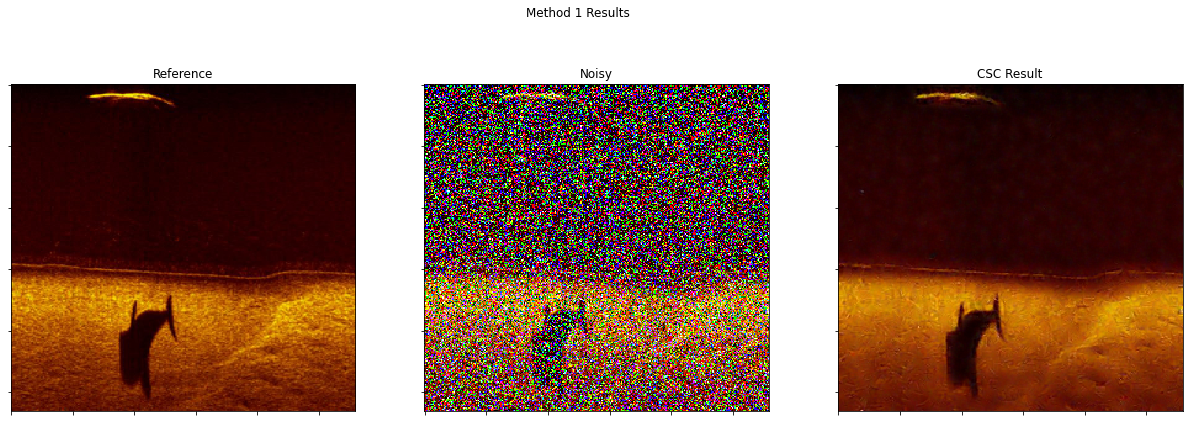

In [67]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(21, 7))
fig.suptitle('Method 1 Results')
plot.imview(img, ax=ax[0], title='Reference', fig=fig)
plot.imview(imgn, ax=ax[1], title='Noisy', fig=fig)
plot.imview(imgd, ax=ax[2], title='CSC Result', fig=fig)
fig.show()

In [68]:
from skimage.metrics import structural_similarity as ssim
ssim_const_1 = ssim(img, imgd,
                  data_range=imgd.max() - imgd.min(), multichannel=True)

print(ssim_const_1)#structure similarity between two random variables -it measures contrast,variance,mean, luminous,covariance 

0.739681539178812


In [69]:
class ConvRepL1L1(cbpdn.ConvBPDNMaskDcpl):

    def ystep(self):

        AXU = self.AX + self.U
        Y0 = sp.prox_l1(self.block_sep0(AXU) - self.S, (1.0/self.rho)*self.W)
        Y1 = sp.prox_l1(self.block_sep1(AXU), (self.lmbda/self.rho)*self.wl1)
        self.Y = self.block_cat(Y0, Y1)

        super(cbpdn.ConvBPDNMaskDcpl, self).ystep()


    def obfn_g0(self, Y0):

        return np.sum(np.abs(self.W * self.obfn_g0var()))

In [70]:
opt = ConvRepL1L1.Options({'Verbose': True, 'MaxMainIter': 200,
                    'RelStopTol': 5e-3, 'AuxVarObj': False,
                    'rho': 1e1, 'RelaxParam': 1.8})

In [71]:
lmbda = 3.0e0
b = ConvRepL1L1(D0, pad(imgn) - imglp, lmbda, opt=opt, dimK=0)
X = b.solve()

Itn   Fnc       DFid      Regℓ1     r         s       
------------------------------------------------------
   0  3.00e+05  5.22e+04  8.25e+04  4.36e-01  2.30e+00
   1  3.16e+05  6.54e+04  8.35e+04  3.39e-01  2.16e+00
   2  2.52e+05  5.95e+04  6.42e+04  2.53e-01  1.92e+00
   3  2.00e+05  5.89e+04  4.70e+04  1.94e-01  1.78e+00
   4  1.60e+05  5.79e+04  3.40e+04  1.50e-01  1.51e+00
   5  1.35e+05  5.68e+04  2.62e+04  1.20e-01  1.28e+00
   6  1.21e+05  5.67e+04  2.15e+04  9.95e-02  1.05e+00
   7  1.10e+05  5.65e+04  1.79e+04  8.38e-02  9.11e-01
   8  1.02e+05  5.62e+04  1.52e+04  7.18e-02  8.11e-01
   9  9.47e+04  5.59e+04  1.29e+04  6.22e-02  7.18e-01
  10  8.92e+04  5.57e+04  1.12e+04  5.48e-02  6.46e-01
  11  8.48e+04  5.55e+04  9.77e+03  4.87e-02  5.81e-01
  12  8.16e+04  5.53e+04  8.76e+03  4.38e-02  5.31e-01
  13  7.89e+04  5.53e+04  7.88e+03  3.97e-02  4.83e-01
  14  7.70e+04  5.52e+04  7.27e+03  3.64e-02  4.44e-01
  15  7.53e+04  5.52e+04  6.71e+03  3.36e-02  4.07e-01
  16  7.39

 147  5.79e+04  5.44e+04  1.15e+03  2.64e-03  1.88e-02
 148  5.79e+04  5.44e+04  1.14e+03  2.62e-03  1.86e-02
 149  5.78e+04  5.44e+04  1.14e+03  2.59e-03  1.85e-02
 150  5.78e+04  5.44e+04  1.13e+03  2.57e-03  1.83e-02
 151  5.78e+04  5.44e+04  1.13e+03  2.56e-03  1.81e-02
 152  5.78e+04  5.44e+04  1.13e+03  2.54e-03  1.79e-02
 153  5.78e+04  5.44e+04  1.12e+03  2.52e-03  1.77e-02
 154  5.78e+04  5.44e+04  1.12e+03  2.50e-03  1.75e-02
 155  5.78e+04  5.44e+04  1.12e+03  2.48e-03  1.73e-02
 156  5.78e+04  5.44e+04  1.11e+03  2.46e-03  1.71e-02
 157  5.78e+04  5.44e+04  1.11e+03  2.44e-03  1.70e-02
 158  5.78e+04  5.44e+04  1.11e+03  2.42e-03  1.69e-02
 159  5.77e+04  5.44e+04  1.10e+03  2.41e-03  1.67e-02
 160  5.77e+04  5.44e+04  1.10e+03  2.39e-03  1.65e-02
 161  5.77e+04  5.44e+04  1.09e+03  2.37e-03  1.63e-02
 162  5.77e+04  5.44e+04  1.09e+03  2.35e-03  1.62e-02
 163  5.77e+04  5.44e+04  1.09e+03  2.34e-03  1.60e-02
 164  5.77e+04  5.44e+04  1.08e+03  2.32e-03  1.58e-02
 165  5.77

In [72]:
imgdp = b.reconstruct().squeeze() + imglp
imgd = crop(imgdp)

In [73]:
print("ConvRepL1L1 solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Noisy image PSNR:    %5.2f dB" % sm.psnr(img, imgn))
print("Denoised image PSNR: %5.2f dB" % sm.psnr(img, imgd))

ConvRepL1L1 solve time: 2483.13 s
Noisy image PSNR:     7.69 dB
Denoised image PSNR: 31.34 dB


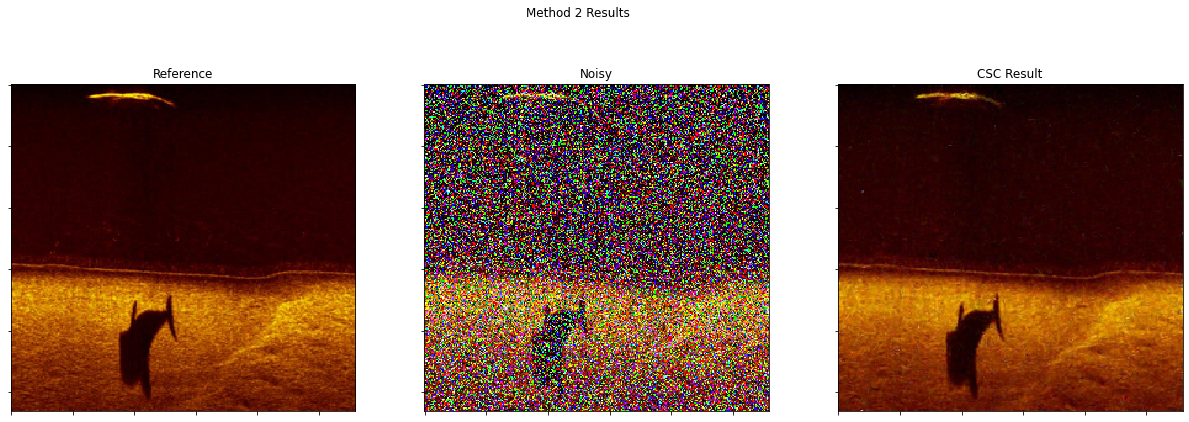

In [74]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(21, 7))
fig.suptitle('Method 2 Results')
plot.imview(img, ax=ax[0], title='Reference', fig=fig)
plot.imview(imgn, ax=ax[1], title='Noisy', fig=fig)
plot.imview(imgd, ax=ax[2], title='CSC Result', fig=fig)
fig.show()

In [75]:
from skimage.metrics import structural_similarity as ssim
ssim_const_1 = ssim(img, imgd,
                  data_range=imgd.max() - imgd.min(), multichannel=True)

print(ssim_const_1)#structure similarity between two random variables -it measures contrast,variance,mean, luminous,covariance 

0.8081813104973375
